In [1]:
!pip install pennylane scikit-learn numpy

import numpy as np
import pennylane as qml
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# 1) Bigger corpus (20 lines) for fitting TF-IDF
corpus = [
    "stocks fell after market crash",
    "equities rallied as prices rose",
    "bond yields climbed amid inflation concerns",
    "football team won the championship after penalties",
    "cricket world cup final draws massive audience",
    "deep learning improves language models",
    "transformers achieve state of the art in NLP",
    "quantum circuits encode high dimensional information",
    "quantum entanglement enhances sensing precision",
    "healthy diet includes fruits vegetables and whole grains",
    "exercise improves cardiovascular health and stamina",
    "new smartphone features advanced camera and battery",
    "laptops with efficient cooling perform better under load",
    "travel guide for budget backpacking across asia",
    "best street food markets in southeast asia",
    "movie review praises strong performances and script",
    "documentary explores climate change impacts on oceans",
    "startup raises funding to build ai education platform",
    "fintech app launches instant payments and lending",
    "machine learning helps detect credit card fraud",
]

# Vectorize (classical). You can raise max_features if you like.
vectorizer = TfidfVectorizer(max_features=256, stop_words="english")
X = vectorizer.fit_transform(corpus).toarray()

# 2) Reduce to 4 dims (=> 4 qubits)
pca = PCA(n_components=4, random_state=0)
X4 = pca.fit_transform(X)

# Normalize features to a safe rotation range (e.g., [-pi, pi])
def normalize_to_pi(x):
    x = x - x.mean()
    s = np.std(x) + 1e-8
    return np.clip(x / s, -3, 3) * (np.pi / 3)

# 3) Quantum device
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# 4) Variational block (optional: you can train these params)
def feature_map(features):
    # Angle encoding
    for i in range(n_qubits):
        qml.RY(features[i], wires=i)
    # Basic entanglement
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

def ansatz(weights):
    # One simple trainable layer
    for i in range(n_qubits):
        qml.RZ(weights[i, 0], wires=i)
        qml.RX(weights[i, 1], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

# Random (untrained) weights just to demo the flow
rng = np.random.default_rng(0)
weights = rng.normal(0, 0.1, size=(n_qubits, 2))

# 5) Define the embedding circuit (measure Z on each qubit)
@qml.qnode(dev)
def embed_circuit(features, weights):
    feature_map(features)
    ansatz(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def quantum_embed(text):
    # vectorize → PCA → normalize → quantum → embedding
    vec = vectorizer.transform([text]).toarray()
    vec4 = pca.transform(vec)[0]
    feats = normalize_to_pi(vec4)
    return np.array(embed_circuit(feats, weights))

def quantum_embed_many(texts):
    return np.vstack([quantum_embed(t) for t in texts])

# Bigger input to embed (≈20 lines). You can just set texts = corpus, too.
texts = [
    "stock prices dropped in the market",
    "equities extended gains on strong earnings",
    "central bank hikes rates to tame inflation",
    "team clinches title in dramatic final",
    "batsman hits century in world cup thriller",
    "new transformer model improves translation quality",
    "large language models power next gen assistants",
    "quantum circuits enable expressive state encoding",
    "entangled qubits improve interferometry limits",
    "diet rich in fiber linked to longevity",
    "aerobic exercise boosts endurance and mood",
    "flagship phone debuts with periscope camera",
    "gaming laptop sustains performance under stress",
    "budget travel hacks for southeast asia",
    "street food tour highlights local delicacies",
    "film wins awards for screenplay and acting",
    "climate documentary spotlights ocean warming",
    "edtech startup secures seed funding round",
    "payments app rolls out instant transfers",
    "anomaly detection catches fraudulent transactions",
]

embeddings = quantum_embed_many(texts)
print("Embeddings shape:", embeddings.shape)  # should be (20, 4)
print(embeddings[:3])  # preview first 3 rows


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 36.5 MB/s eta 0:00:00
Embeddings shape: (20, 4)
[[0.80954897 0.22728545 0.65587384 0.04332388]
 [0.80506753 0.26090206 0.69506854 0.03227063]
 [0.92956847 0.96900613 0.17773085 0.06191199]]


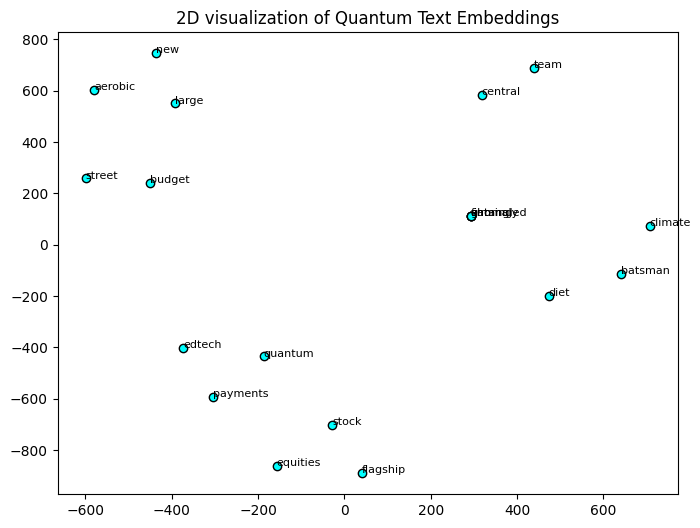

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

emb_2d = TSNE(n_components=2, random_state=0, perplexity=5).fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c='cyan', edgecolor='k')
for i, text in enumerate(texts):
    plt.text(emb_2d[i,0]+0.02, emb_2d[i,1], text.split()[0], fontsize=8)
plt.title("2D visualization of Quantum Text Embeddings")
plt.show()


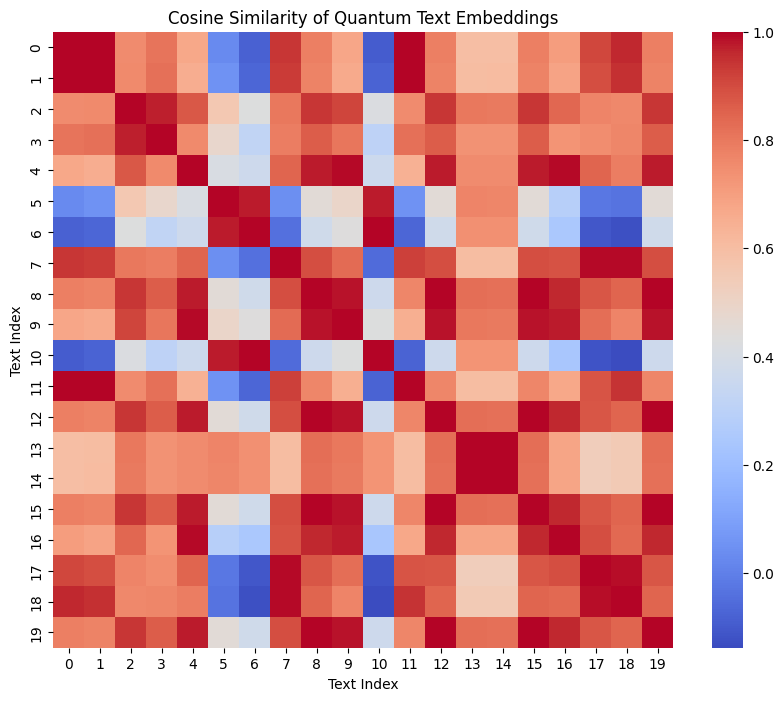

In [4]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

sim_matrix = cosine_similarity(embeddings)

plt.figure(figsize=(10,8))
sns.heatmap(sim_matrix, cmap="coolwarm", annot=False)
plt.title("Cosine Similarity of Quantum Text Embeddings")
plt.xlabel("Text Index")
plt.ylabel("Text Index")
plt.show()


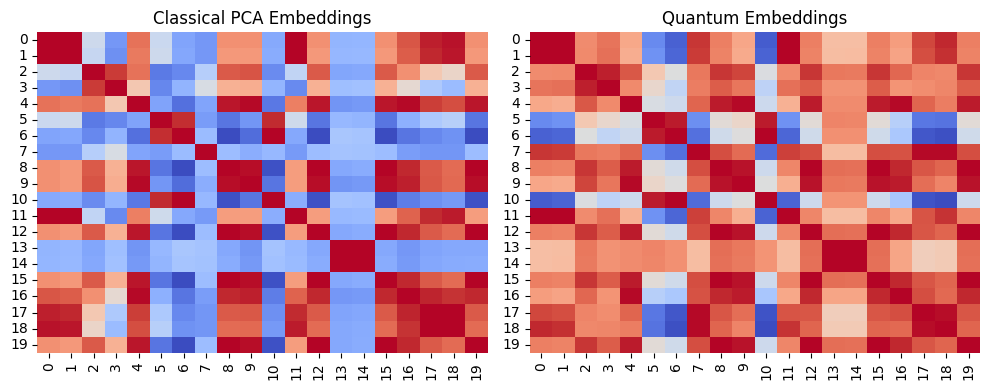

In [5]:
X_classical = pca.transform(vectorizer.transform(texts).toarray())
sim_classical = cosine_similarity(X_classical)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(sim_classical, cmap="coolwarm", cbar=False)
plt.title("Classical PCA Embeddings")

plt.subplot(1,2,2)
sns.heatmap(sim_matrix, cmap="coolwarm", cbar=False)
plt.title("Quantum Embeddings")
plt.tight_layout()
plt.show()


In [6]:
def most_similar(query):
    q_emb = quantum_embed(query)
    sims = cosine_similarity([q_emb], embeddings)[0]
    top = sims.argsort()[-3:][::-1]
    print(f"\n🔍 Query: {query}")
    for i in top:
        print(f"  → ({sims[i]:.3f}) {texts[i]}")

# Try some
most_similar("quantum technology applications")
most_similar("healthy lifestyle and exercise")
most_similar("stock market crash news")



🔍 Query: quantum technology applications
  → (0.982) climate documentary spotlights ocean warming
  → (0.965) edtech startup secures seed funding round
  → (0.956) quantum circuits enable expressive state encoding

🔍 Query: healthy lifestyle and exercise
  → (0.992) large language models power next gen assistants
  → (0.992) aerobic exercise boosts endurance and mood
  → (0.950) new transformer model improves translation quality

🔍 Query: stock market crash news
  → (1.000) diet rich in fiber linked to longevity
  → (0.995) batsman hits century in world cup thriller
  → (0.984) anomaly detection catches fraudulent transactions
